In [4]:
import tensorflow as tf
import numpy as np

### 트랜스포머

트랜스포머에 대해서 더 깊게 이해해보고 싶어서 코드를 구현하면서 공부하는 노트입니다.

모든 코드는 https://wikidocs.net/31379 에서 가져왔습니다. 

트랜스포머에는 d_model, num_layers, num_heads, d_ff 라는 주요 하이퍼 파라미터가 있다.

- d_model: 모델의 인코더와 디코더에서 입력과 출력의 크기. 임베딩벡터의 차원이다.

- num_layers: 인코더와 디코더의 구성 층 개수

- num_heads: 어텐션을 사용할 때, 한 번하는 것 보다 여러개로 분할해서 병렬로 어텐션을 수행하고 결과값을 합치는 방식을 사용. 병렬의 개수

- d_ff: 피드 포워드 신경망에서의 은닉층 크기. 피드 포워드 신경망의 입력과 출력의 크기는 d_model 이다. 

트랜스포머는 RNN과 다르게 순차적으로 데이터가 입력되지 않기 때문에 positional encoding을 통해서 데이터의 순서를 알려주어야 한다. 

일단 그거는 미뤄두고 어텐션 부터 공부하겠음.

아래는 대략적인 트랜스포머 그림이다.

### positional encoding

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

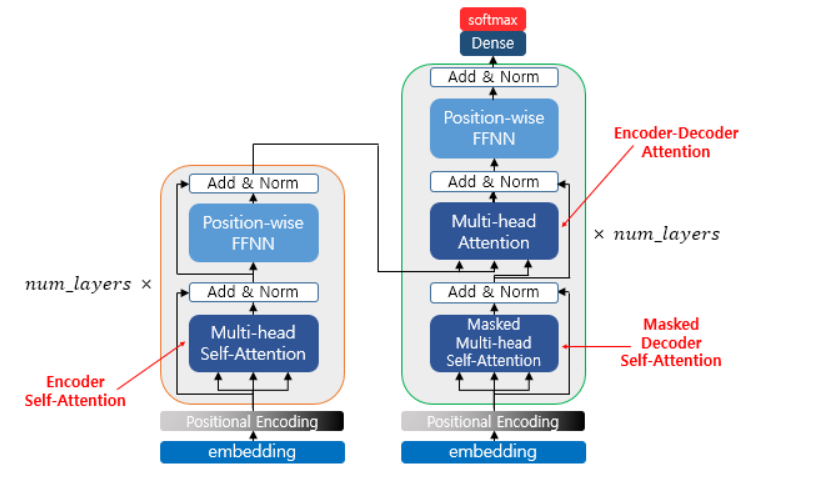

Transfomer은 self-Attention을 사용하는데 이건 Q,K,V가 모두 같은 것이다. 즉, 데이터 스스로 Q를 보내면 데이터가 Key와 Value를 찾는 것이다. 

Q, K, V가 좀 헷갈린다. 이게 뭐냐면 Q(쿼리)를 요청해서 K(key)로 V(value)를 얻는 과정이다.

그러니까 트랜스포머에서는 Q에 대한 어텐션점수(V)를 구해주세요~ 하면 K(key)를 통해서 V(점수)를 구하는 거다.

원래 어텐션의 과정은 아래 그림과 같다.

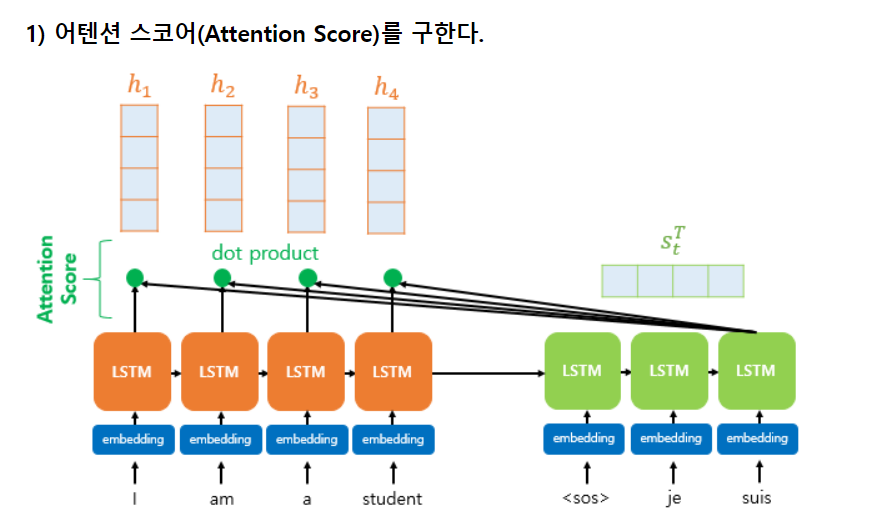

위와 같이 인코더의 은닉층에 디코더의 벡터를 내적해서 유사도를 구한다.  

행렬 내적을 하면 유사도를 구할 수 있다는건 이제 알고 있다 ㅋ

트랜스포머에서 셀프 어텐션은 입력 문장의 단어 벡터들을 가지고 수행한다고 했는데, 사실 셀프 어텐션은 인코더의 초기입력인 d_model 차원을 가지는 단어 벡터들을 사용해서 셀프 어텐션을 수행하는 것이 아니라 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거친다. 이때 Q벡터, K벡터, V벡터는 초기 입력인 d_model/ num_heads로 나눈 값을 차원으로 가진다.

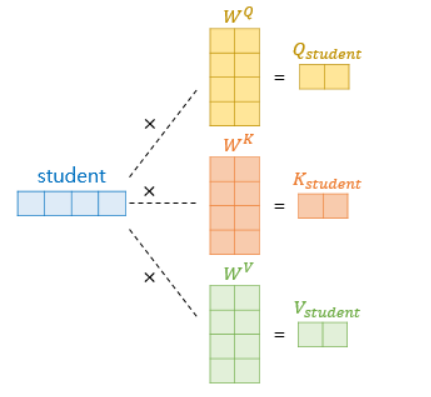

위는 예시 그림이다. 

또한 어텐션은 Scaled dot-product attention을 사용한다. 이거는 기존의 Attention score를 sqrt(입력벡터의 차원)으로 나누어준 값이다.

그 다음 과정으로는 Scaled dot attention을 사용한 값을 softmax 함수에 넣고, 얻은 값을 각 V벡터와 가중합 해서 최종적인 Attention value를 구한다. 아래는 예시 그림이다. 

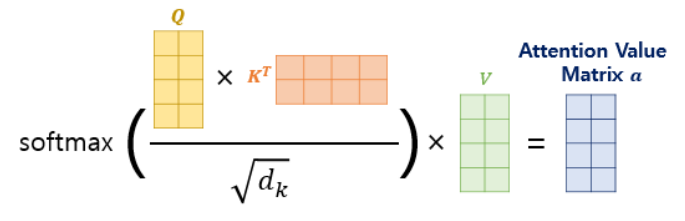

#### 여기서 드는 의문
1. 가중치의 초기 상태는 어떻게 정해질까?
wieght initialization이라는 분야에서 전문적으로 다루는 듯하다. 잠깐 봤는데 양이 한사바리다. 일단 <b>PASS</b>
2. 왜 Scaled dot-product를 해야할까? 
Q와 K의 길이가 커질 수록 내적값 역시 커질 가능성이 높아진다고 한다. 여기서 문제가 발생하는데 이렇게 되면 softmax의 기울기가 0인 영역에 도달하기 쉬워진다. 즉, gradient vanishing이 일어나게 되는것이다. 그렇기 때문에 scale을 해주면 이런 문제가 해결 될 수 있다.

왜 차원이 길어질수록 softmax의 기울기가 0인 영역에 도달하기 쉬울까?? 

-> q_i와 k_i가 i.i.d N(0,1)분포를 따를 때, E(q_\i * k_\i) = 0, Var(q_i * k_i)=0 이다. <br>
그렇게 되면 sum(i=1~dk)q_i*k_i ~ N(0,d_k) 분포를 따른다. 하지만 스케일링을 해주면 N(0,1)을 따르기 때문에 gradient vanishing 문제를 완화할 수 있다.

In [6]:
import tensorflow as tf

def scaled_dot_product_attention(Q, K, V, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 내적을 구한다.
    matmul_qk = tf.matmul(Q,K,transpose_b=True)

    # 스케일링
    depth = tf.cast(tf.shape(K)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹 
    # 이거는 아래서 배운당
    if mask is not None:
        logits += (mask * -1e9)
    
    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)

    # 나는 아래 axis=-1을 Q*K.T 니까 결국 K의 행 길이로 이루어 진다고 생각했다. 
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, V)

    return output, attention_weights

와우 위에 코드를 이해하면서 작성했다. 굉장히 뿌듯함. ㅋㅋㅋㅋ 재밌당

In [7]:
import numpy as np

np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


### 어텐션
위에 코드는 입력벡터를 d_model 차원이 아니라 낮춰서 어텐션을 진행했다. 

왜 그러냐면, d_model 차원으로 어텐션을 한번 진행하는 것보다 d_model/num_heads 차원으로 num_heads 번 진행하는게 효율적이라고 연구자들이 판단했기 떄문이다. 나도 그렇게 생각한다. 오케이 굳

그러면 병렬적으로 self-attention을 진행하고 concat 해주면 된다. 그러면 최종적인 차원이 (seq_len, d_model)이 된다.

마지막으로 (d_model, d_model)차원인 W_O를 곱한다. 

마지막에 W_O를 곱하는 이유는 아래와 같다. (G모씨의 고마운 조언이 있었다).

------

이렇게 concat 후 내적하는 이유는, 각 헤드에서 얻은 어텐션 값들은 서로 다른 측면(aspect)에서 정보를 추출하기 때문입니다. 예를 들어, 어텐션 메커니즘을 사용하여 번역을 수행하는 경우, 각 헤드는 다른 단어의 중요도를 파악하거나, 다른 문법적인 특성을 추출할 수 있습니다. 따라서, 이러한 서로 다른 측면에서 얻은 정보들을 합쳐 최종 출력 값을 계산함으로써 보다 정확하고 풍부한 정보를 반영할 수 있습니다.

그리고 이 때 w^O를 사용하여 다시 내적(dot product)하는 이유는, 최종 출력 값의 차원을 원하는 차원으로 맞추기 위해서입니다. 즉, concat된 벡터와 가중치 행렬을 내적하면, 최종 출력 값의 차원은 가중치 행렬의 열의 수와 같아지게 됩니다. 이를 통해, 최종 출력 값을 원하는 차원으로 조정할 수 있습니다.

### 멀티 헤드 어텐션 구현

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__ (self, d_model, num_heads, name="multi_head_attention"):
        # super 메소드로 상속시에 상속받는 대상, self를 인수로 넣어줘서 더 명확하게 할 수 있다.
        super(MultiHeadAttention, self).__init__(name=name) # 이 부분 코드 뭐지...? 상속 다시 공부하쟈...
        self.num_heads = num_heads
        self.d_model = d_model

        # assert 구문은 오류를 띄워주는 코드이다.
        assert d_model % self.num_heads == 0 # assert 구문도 공부하쟈

        # 쪼개진 입력벡터의 크기
        self.depth = d_model // num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        # d_model의 크기를 가지는 밀집층을 정의한다. 이렇게 하면 (seq_len,d_model)의 가중치를 가지는 것과 같은 것이다. 
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q,k,v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        # 이부분 이해 잘 못하겠다. 아래 코드를 먼저 봐보고 이해해보자

        # 이 코드는 inputs을 reshape하는 코드이다.
        # input_size는 (batch_size, seq_len, d_model)로 입력될 것이다.
        
        # 일단 shape를 (batch_size, -1, numheads, depth)로 reshape한다.
        # seq_len -1로 하는 이유는 길이가 바뀔 수 있기 때문이다.

        # 그런 다음에 (batch_size, num_head, seq_len, depth)로 transpose해주는 것이다.

        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
        
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'],\
                                    inputs['value'], inputs['mask']
        # batch_size는 뭘로 정해지는 건지 모르겠다.
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q: (batch_size, num_heads, query_seq_len, d_model/num_heads)
        # k: (batch_size, num_heads, key_seq_len, d_model/num_heads)
        # v: (batch_size, num_heads, value_seq_len, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. scaled dot-product attention
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size,query의 문장 길이,  num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])


        # 4. head 연결하기 (concatenate)
        # (batch_Size,query_seq_len, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. WO 가중치 내적(밀집층 지나는 것과 같음)
        # (batch_size, qeury_seq_len, d_model)
        outputs = self.dense(concat_attention)

        return outputs

위 코드를 이해하면서 작성했다. 

위 코드의 어려웠던 부분은 transpose이다. <br>
이게 왜그러냐면 문장이 입력될 때는 (문장길이, 임베딩벡터 크기)로 입력된다. 하지만 우리는 multi head attention을 진행한다. 그렇기 때문에 임베딩 벡터 크기를 (헤드 개수,임베딩벡터크기/헤드 개수) 크기의 행렬로 바꿔주어야 한다. 

그렇게 하면 인풋이 (seq_len, num_heads, 작아진 임베딩 벡터)로 바뀐다. 

우리는 num_heads별로 "병렬"적으로 학습을 진행한 다음에 다시 합쳐야 하기 때문에 (num_heads, seq_len, 작아진 임베딩 벡터)로 바꾸어준다. 

그런다음에 output으로 나갈 때는 다시 (seq_len, 임베딩 벡터 크기)로 바꿔서 내보내는 것이다!!!!!!!!!!!!!!!!!!

### Padding Mask

위에 scaled dot-product를 작성하다가 mask라는 것이 있었는데 여기서는 그걸 알아볼 것이다. 

``` python
def scaled_dot_product_attention(query, key, value, mask):
... 중략 ...
    if mask is not None:
        logits += (mask * -1e9)
    # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있다.
... 중략 ...
```

이는 입력 문장에 \<PAD> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산입니다.

패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것입니다. 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.

In [9]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

위 함수는 패딩마스크를 만드는 코드인데 이해는 가는데 나중에 인풋값을 예시로 생각하면서 이해하는게 좋을 듯 하다. 

###포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)

지금까지는 인코더에 대해서만 알아봤지만, 포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지는 서브층이다. 포지션 와이즈 FFNN은 쉽게 말하면 완전연결 FFNN이라고 해석가능하다.

식은 <br>
FFNN(x) = MAX(0, xW_1 + b_1)W_2 + b_2




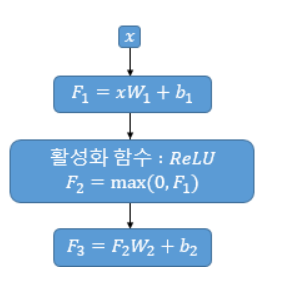

여기서 x는 멀티헤드 어텐션의 결과로 나온 (seq_len, d_model)의 크기를 가지는 행렬을 말한다. 가중치 행렬 W_1은 (d_model, d_ff)크기이고 가중치 행렬 W_1은 (d_ff, d_model)크기이다. 

여기서 가중치와 편향은 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용됩니다. 하지만 인코더 층마다는 다른 값을 가집니다.

``` python
# 다음의 코드는 인코더와 디코더 내부에서 사용할 예정입니다.
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  ```

####여기서 궁금한점

왜 FFNN을 사용할까??? 그냥 attention value를 그대로 넣어줘도 되지 않나??? 

일단 내 생각에는 가중치를 많이 부여함으로써 더 정확한 예측을 하기 위함이라고 생각된다. 

G모씨의 답변이다. 

FFNN층은 트랜스포머에서 두 가지 주요한 이유로 사용됩니다.

첫째, FFNN층은 멀티헤드 어텐션층의 출력에 대한 비선형성을 도입하여, 모델의 표현 능력을 향상시킵니다. 즉, FFNN층은 멀티헤드 어텐션층에서 얻은 정보를 더 복잡한 형태로 다음 층으로 전달해주는 역할을 합니다.

둘째, FFNN층은 멀티헤드 어텐션층에서 얻은 정보를 모두 사용하여 문장의 다양한 측면을 고려한 표현을 생성합니다. 반면에 멀티헤드 어텐션층은 각각의 어텐션 헤드에서 다른 측면을 강조하는 표현을 생성합니다. 이러한 이유로 FFNN층과 멀티헤드 어텐션층은 서로 보완적인 역할을 수행하여, 효과적인 텍스트 분류 및 번역 모델을 구현할 수 있습니다.

내 생각이 "대충"은 맞는 것 같다. 오케잉~~

### 잔차 연결과 층 정규화
인코더에서는 위에서 공부한 두 개의 서브층에 대해서 Add & Norm을 진행한다.

#### 잔차연결
잔차연결은 주로 이미지 인식분야에서 사용되는 것이다. FFNN층에 들어가기 전 값과 나온 후의 값이 같기 때문에 잔차연결을 할 수 있다. 

아래는 그림이다.

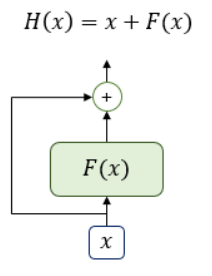

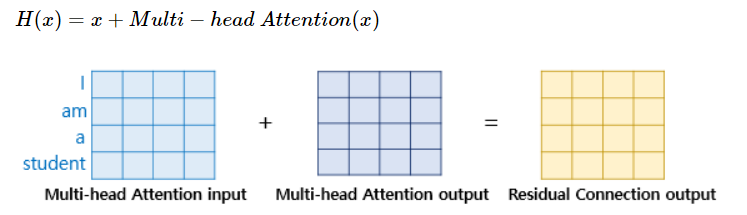

#### 층 정규화
층 정규화는 데이터의 마지막 차원을 기준으로 정규화 하는 것이다. 

### 인코더 구현하기
위에서 공부한 것을 바탕으로 인코더를 구현 할 수 있따.

In [10]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩마스크를 사용한다.
    # 이 코드는 잘 모르겠다.

    # 원래 padding_mask의 shape가 이런것 같다!!!!
    
    padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

    # 멀티 헤드 어텐션
    # inputs과 padding_mask를 입력을 받는다.
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query' : inputs, 'key': inputs, 'value': inputs,
            'mask': padding_mask
        })
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # FFNN 층
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
    )

위와 같이 인코더를 구성할 수 있다. 

하지만 인코더는 여러겹의 인코더가 쌓인 형태이기 때문에 쌓아 주어야 한다.



In [11]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

####여기서 드는 의문
padding mask는 모두 똑같나??? 
그리고 인풋에서 padding mask가 들어가지 않는 것 같은데...
<br> A. 매 입력마다 \<pad>자리를 무효화 해주어야하기 때문에 매번 padding_mask가 입력으로 들어가는 것이다.

### 인코더에서 디코더로

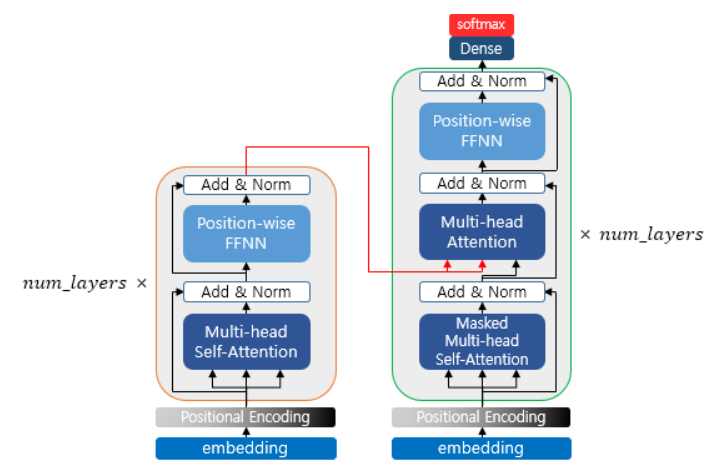

위 그림과 같이 디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력됩니다. 트랜스포머 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 \<sos> je suis étudiant의 문장 행렬을 한 번에 입력받습니다. 그리고 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련됩니다.

여기서 문제가 있습니다. seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 입력받으므로 다음 단어 예측에 현재 시점을 포함한 이전 시점에 입력된 단어들만 참고할 수 있습니다. 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생합니다. 가령, suis를 예측해야 하는 시점이라고 해봅시다. RNN 계열의 seq2seq의 디코더라면 현재까지 디코더에 입력된 단어는 \<sos>와 je뿐일 것입니다. 반면, 트랜스포머는 이미 문장 행렬로 \<sos> je suis étudiant를 입력받았습니다.

이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 도입했습니다. 직역하면 '미리보기에 대한 마스크'입니다.

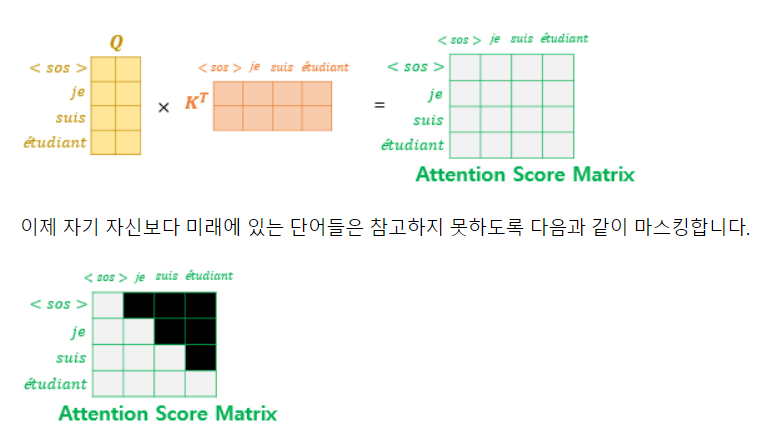

아래 코드는 미래 토큰을 보지 못하게 마스킹을 진행하는 코드이다.

In [12]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [13]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [16]:
print("(batch_size, num_heads, seq_len, d_model/num_heads): ",create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])).shape)

(batch_size, num_heads, seq_len, d_model/num_heads):  (1, 1, 5, 5)


디코더의 첫번째 서브층에서의 위에서 마스킹한 행렬로 셀프어텐션을 진행한다.

### 디코더의 두번째 서브층
디코더의 두번째 서브층은 셀프 어텐션이 아니다.

디코더 그림에서 두번째 서브층을 자세히 보면 입력이 두개인 것을 볼 수 있다. 

인코더의 첫번째 서브층 : Query = Key = Value<BR>
디코더의 첫번째 서브층 : Query = Key = Value<BR>
디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬

디코더의 두번째 서브층은 key= value는 인코더의 행렬이고 query는 디코더의 행렬이다. 

이는 간단하게 생각하면 이해하기 쉬운것 같다. qeury(즉, 어텐션 스코어를 구하고 싶은 대상)를 인코더에서 이용된 key와 value에 맞춰서 해석하는 것이라고 생각하면 될 듯 하다. 아래는 그림이다.

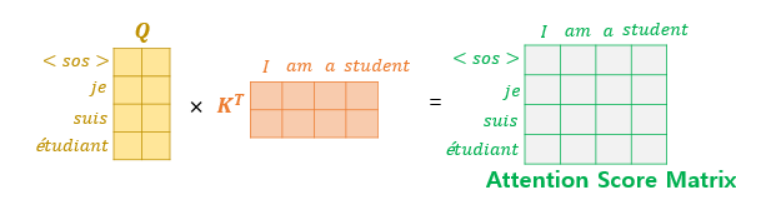

### 디코더 구현하기

In [18]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.kears.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(
        shape=(1,None,None), name="look_ahead_mask"
    )

    # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 패딩 마스크(첫번째 서브층 / 마스크트 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': look_ahead_mask # 룩어헤드 마스크            
        })
    
    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)    
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNomalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


### 디코더 쌓기

In [19]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 트랜스포머 구현

In [20]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    '''
    # 아래에서 Inputs의 shape를 (None, 1)로 받는 이유는 
    # 실제로 모델이 입력받는 데이터가 (batch_size, seq_len)이기 때문이다.
    '''

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")


    '''
    # lambda layer에서 output_shape를 (1, 1, None)로 한 이유는
    # (batch_size, 1, 1, seq_len)으로 만들기 위하이다. 
    # seq_len은 가변이기 때문에 None으로 설정했다.
    # 1은 마스킹을 하기위한 추가적인 차원이다. 
    '''
    
    # 또한 계산이 진행되는 층에서는 자연스럽게 batch_size를 생략한다.

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    # This padding mask is used to mask the encoder outputs.
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

위 코드가 트랜드포머이다. 

트랜스포머는 인코딩 층에서 self-attention을 통한 어텐션 점수를 디코딩 층에서  dec_input를 self-attnetion해서 얻은 어텐션 점수를 attention해서 최종적인 attention을 받는 원리 인것 같다.

위 모델을 만들기 위해
- position encoding
- masking
- 잔차연결 / 층 정규화
- FFNN layer 

과 같은 방법도 사용된다. 

개인적으로 masking 하는 것이 잘 이해되지 않고, shape가 헷갈리는것 같다. 

하지만 내 생각에는 self-attention이 중요한 포인트 같다. 

다음으로는 TFT논문을 읽고 코드까지 공부해보겠다.